In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
%matplotlib notebook
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


Run for RIXS

In [3]:
def load_data(load_name_base, scannum):
    load_name = load_name_base
    
    for jj in range(0, len(scannum)):
        load_name = load_name + '%02d' % scannum[jj] + '_'
    
    eV_on = np.load(load_name + 'eV_on.npy')
    eV_off = np.load(load_name + 'eV_off.npy')
    RIXS_on = np.load(load_name + 'RIXS_on.npy')
    RIXS_off = np.load(load_name + 'RIXS_off.npy')
    Fluo_pump = np.load(load_name + 'Fluo_pump.npy')
    Fluo_unpump = np.load(load_name + 'Fluo_unpump.npy')
    
    return eV_on, eV_off, RIXS_on, RIXS_off, Fluo_pump, Fluo_unpump

In [4]:
def plot_rixs_plane(label, axes_range, scannum, eV_on, eV_off, RIXS_on, RIXS_off):

    RIXS_diff = RIXS_on - RIXS_off
    X,Y = np.meshgrid(np.linspace(0,RIXS_on.shape[1],RIXS_on.shape[1]+1),eV_on)

    plt.figure(figsize=(5,5))
    plt.subplot(3,1,1)
    plt.pcolormesh(X,Y,RIXS_on, vmax = 0.3)
    plt.colorbar()
    plt.xlabel('JF pixel')
    plt.ylabel('Mono Energy (eV)')
    plt.title(label + ', scannum ' + str(scannum) + ' on')
    plt.axis(axes_range)

    X,Y = np.meshgrid(np.linspace(0,RIXS_off.shape[1],RIXS_off.shape[1]+1),eV_off)
    plt.subplot(3,1,2)
    plt.pcolormesh(X,Y,RIXS_off, vmax = 0.3)
    plt.colorbar()
    plt.xlabel('JF pixel')
    plt.ylabel('Mono Energy (eV)')
    plt.title(label + ', scannum ' + str(scannum) + ' off')
    plt.axis(axes_range)

    X,Y = np.meshgrid(np.linspace(0,RIXS_off.shape[1],RIXS_off.shape[1]+1),eV_off)
    plt.subplot(3,1,3)
    plt.pcolormesh(X,Y,RIXS_diff, vmin = -0.1, vmax = 0.1)
    plt.colorbar()
    plt.xlabel('JF pixel')
    plt.ylabel('Mono Energy (eV)')
    plt.title(label + ', scannum ' + str(scannum) + ' on - off')
    plt.axis(axes_range)

    plt.tight_layout()
    

In [5]:
def plot_projected_XAS(label, scannum, eV_on, eV_off, RIXS_on, RIXS_off, Fluo_pump, Fluo_unpump):

    plt.figure(figsize=(8,12))
    plt.subplot(4,1,1)
    plt.plot(eV_on, RIXS_on.sum(axis=1), label = "on")
    plt.plot(eV_off, RIXS_off.sum(axis=1), label = 'off')
    plt.xlabel('Mono Energy')
    plt.title(label + ', projected XAS scannum ' + str(scannum))
    plt.legend()

    plt.subplot(4,1,2)
    plt.plot(eV_off, RIXS_on.sum(axis=1)-RIXS_off.sum(axis=1))
    plt.xlabel('Mono Energy')
    plt.title(label + ', projected XAS scannum ' + str(scannum) + ' on - off')

    plt.subplot(4,1,3)
    plt.plot(eV_on, Fluo_pump, label = "on")
    plt.plot(eV_off, Fluo_unpump, label = 'off')
    plt.xlabel('Mono Energy')
    plt.title(label + ', XAS TFY ' + str(scannum))
    plt.legend()

    plt.subplot(4,1,4)
    plt.plot(eV_off, Fluo_pump-Fluo_unpump)
    plt.xlabel('Mono Energy')
    plt.title(label + ', XAS TFY ' + str(scannum) + ' on - off')

    plt.tight_layout()
    

In [6]:
def plot_projected_XES(label, scannum, eV_on, eV_off, RIXS_on, RIXS_off, Fluo_pump, Fluo_unpump):
    
    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(RIXS_on.sum(axis=0), label = "on")
    plt.plot(RIXS_off.sum(axis=0), label = "off")
    plt.xlabel('JF pixels')
    plt.title(label + ', projected XES scannum ' + str(scannum))
    plt.xlim([130,200])

    plt.subplot(2,1,2)
    plt.plot(RIXS_on.sum(axis=0) - RIXS_off.sum(axis=0))
    plt.xlabel('JF pixels')
    plt.title(label + ', projected XES TFY ' + str(scannum) + ' on - off')
    plt.xlim([130,200])

    plt.tight_layout()

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(RIXS_on.sum(axis=0), label = "on")
    plt.plot(RIXS_off.sum(axis=0), label = "off")
    plt.xlabel('JF pixels')
    plt.title(label + ', projected XES scannum ' + str(scannum))
    plt.xlim([130,200])

    plt.subplot(2,1,2)
    plt.plot(RIXS_on.sum(axis=0) - RIXS_off.sum(axis=0))
    plt.xlabel('JF pixels')
    plt.title(label + ', projected XES TFY ' + str(scannum) + ' on - off')
    plt.xlim([130,200])

    plt.tight_layout()

In [7]:
def plot_herfd(label, scannum, pixel_min, pixel_max, eV_on, eV_off, RIXS_on, RIXS_off, Fluo_pump, Fluo_unpump):
    
    title_label = label + 'HERFD, (pixels #' + str(pixel_min) + '-' + str(pixel_max) + ')  scannum ' + str(scannum)
    
    plt.figure(figsize=(8,12))
    plt.subplot(4,1,1)
    plt.plot(eV_on, RIXS_on[:,pixel_min:pixel_max].sum(axis=1), label = "on")
    plt.plot(eV_off, RIXS_off[:,pixel_min:pixel_max].sum(axis=1), label = 'off')
    plt.xlabel('Mono Energy')
    plt.title(title_label)
    plt.legend()

    plt.subplot(4,1,2)
    plt.plot(eV_off, RIXS_on[:,pixel_min:pixel_range_max].sum(axis=1) - RIXS_off[:,pixel_min:pixel_max].sum(axis=1))
    plt.xlabel('Mono Energy')
    plt.title(title_label + ', on - off')

    plt.subplot(4,1,3)
    plt.plot(eV_on, Fluo_pump, label = "on")
    plt.plot(eV_off, Fluo_unpump, label = 'off')
    plt.xlabel(label + 'Mono Energy')
    plt.title('XAS TFY ' + str(scannum))
    plt.legend()

    plt.subplot(4,1,4)
    plt.plot(eV_off, Fluo_pump-Fluo_unpump)
    plt.xlabel(label + 'Mono Energy')
    plt.title('XAS TFY ' + str(scannum) + ' on - off')
    
    diff = RIXS_on[:,pixel_min:pixel_range_max].sum(axis=1) - RIXS_off[:,pixel_min:pixel_max].sum(axis=1)
    diff_fluo = Fluo_pump - Fluo_unpump
    
    plt.tight_layout()
    
    return diff, diff_fluo

In [8]:
def plot_cie(peak_label, label, scannum, mono_range_min, mono_range_max, eV_on, eV_off, RIXS_on, RIXS_off):

    title_label = label + ', XES, ' + peak_label + \
        ':' + str(mono_range_min) + '-' + str(mono_range_max) + 'eV, scannum ' + str(scannum)
        
    index_min = min(min(np.where(eV_on < mono_range_max)))
    index_max = max(max(np.where(eV_on > mono_range_min)))

    print('mono_max')
    print(eV_on[index_min])
    print('mono_min')
    print(eV_on[index_max])
    
    cie_on = RIXS_on[index_min:index_max].sum(axis=0)
    cie_off = RIXS_off[index_min:index_max].sum(axis=0)
    cie_diff = cie_on - cie_off

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(cie_on, label = "on")
    plt.plot(cie_off, label = "off")
    #plt.plot(RIXS_off_01[index_min:index_max].sum(axis=0), label = "off")
    plt.xlabel('JF pixels')
    plt.title(title_label)
    plt.xlim([130,200])
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(cie_diff)
    plt.xlabel('JF pixels')
    plt.title(title_label + ', on - off')
    plt.xlim([130,200])

    plt.tight_layout()

    index_min = min(min(np.where(eV_on < mono_range_max)))
    index_max = max(max(np.where(eV_on > mono_range_min)))

#     print('mono_max')
#     print(eV_on[index_min])
#     print('mono_min')
#     print(eV_on[index_max])
    

#     plt.figure(figsize=(8,6))
#     plt.subplot(2,1,1)
#     plt.plot(RIXS_on[index_min:index_max].sum(axis=0), label = "on")
#     plt.plot((RIXS_off[index_min:index_max].sum(axis=0)), label = "off")
#     plt.xlabel('JF pixels')
#     plt.title(label + 'mono XES scannum ' + str(scannum))
#     plt.xlim([130,200])
#     plt.legend()

#     plt.subplot(2,1,2)
#     plt.plot(RIXS_on[index_min:index_max].sum(axis=0) - (RIXS_off[index_min:index_max].sum(axis=0)))
#     plt.xlabel('JF pixels')
#     plt.title(label + 'mono XES scannum ' + str(scannum) + 'on - off')
#     plt.xlim([130,200])

#     plt.tight_layout()

#     print(index_min)
#     print(index_max)
    
#     noise_level = np.std(cie_diff)
#     print(noise_level.shape)
    
#     print('Standard deviation of difference is: ' + str(noise_level))
    
    return cie_diff
    

Load data

In [9]:
# label_01 = 'RuDimerACN, 0.6 ps, horz, '
# scannum_01 = [10, 11, 12]
# LBASE_01 = '/das/work/p17/p17983/Reduced_data/ROI2/RuDimerACN_0p6ps_scans_'
# eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01, Fluo_pump_01, Fluo_unpump_01 = load_data(LBASE_01, scannum_01)

# label_02 = 'RuDimerACN, 10 ps, horz, '
# scannum_02 = [5, 8, 10, 13]
# LBASE_02 = '/das/work/p17/p17983/Reduced_data/RuDimerACN_10ps_scans_'
# eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02, Fluo_pump_02, Fluo_unpump_02 = load_data(LBASE_02, scannum_02)

# label_02 = 'RuDimerACN, 0.6 ps, horz, '
# scannum_02 = [15, 16, 17, 18]
# LBASE_02 = '/das/work/p17/p17983/Reduced_data/ROI2/RuDimerACN_10ps_scans_'
# eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02, Fluo_pump_02, Fluo_unpump_02 = load_data(LBASE_02, scannum_02)

# label_03 = 'RuDimerACN, 0.6 ps, vert, '
# scannum_03 = [10, 11, 12]
# #scannum_03 = [10]
# LBASE_03 = '/das/work/p17/p17983/Reduced_data/RuDimerACN_0p6ps_scans_'
# eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03, Fluo_pump_03, Fluo_unpump_03 = load_data(LBASE_03, scannum_03)

# label_04 = 'RuDimerACN, 10 ps, vert, '
# scannum_04 = [15, 16, 17, 18]
# LBASE_04 = '/das/work/p17/p17983/Reduced_data/RuDimerACN_10ps_scans_'
# eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04, Fluo_pump_04, Fluo_unpump_04 = load_data(LBASE_04, scannum_04)

# label_01 = 'RuDimerCl, 0.6 ps, horz, '
# scannum_01 = [1, 4, 5]
# scannum_01 = [1]
# LBASE_01 = '/das/work/p17/p17983/Reduced_data/RuDimerCl_0p6ps_scans_'
# eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01, Fluo_pump_01, Fluo_unpump_01 = load_data(LBASE_01, scannum_01)

# label_01 = 'RuDimerCl, 0.6 ps, horz, 0.5 uJ'
# scannum_01 = [10, 11, 12]
# LBASE_01 = '/das/work/p17/p17983/Reduced_data/RuDimerCl_0p6ps_scans_'
# eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01, Fluo_pump_01, Fluo_unpump_01 = load_data(LBASE_01, scannum_01)

label_01 = 'RuDimerCl, 0.6 ps, horz, 0.5 uJ'
scannum_01 = [10, 11, 12]
LBASE_01 = '/das/work/p17/p17983/Reduced_data/RuDimerCl_0p6ps_scans_'
eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01, Fluo_pump_01, Fluo_unpump_01 = load_data(LBASE_01, scannum_01)

Plot RIXS planes

<IPython.core.display.Javascript object>


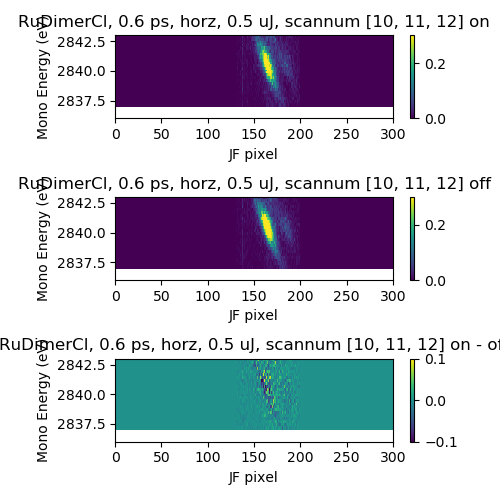

In [10]:
# axes_range = [0, 300, 2831, 2852]
axes_range = [0, 300, 2831, 2852]
axes_range = [0, 300, 2836, 2843] #Shorter range

plot_rixs_plane(label_01, axes_range, scannum_01, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01)

In [11]:
# plot_rixs_plane(label_02, axes_range, scannum_02, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02)

In [12]:
# plot_rixs_plane(label_03, axes_range, scannum_03, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)

In [13]:
# plot_rixs_plane(label_04, axes_range, scannum_04, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

<IPython.core.display.Javascript object>


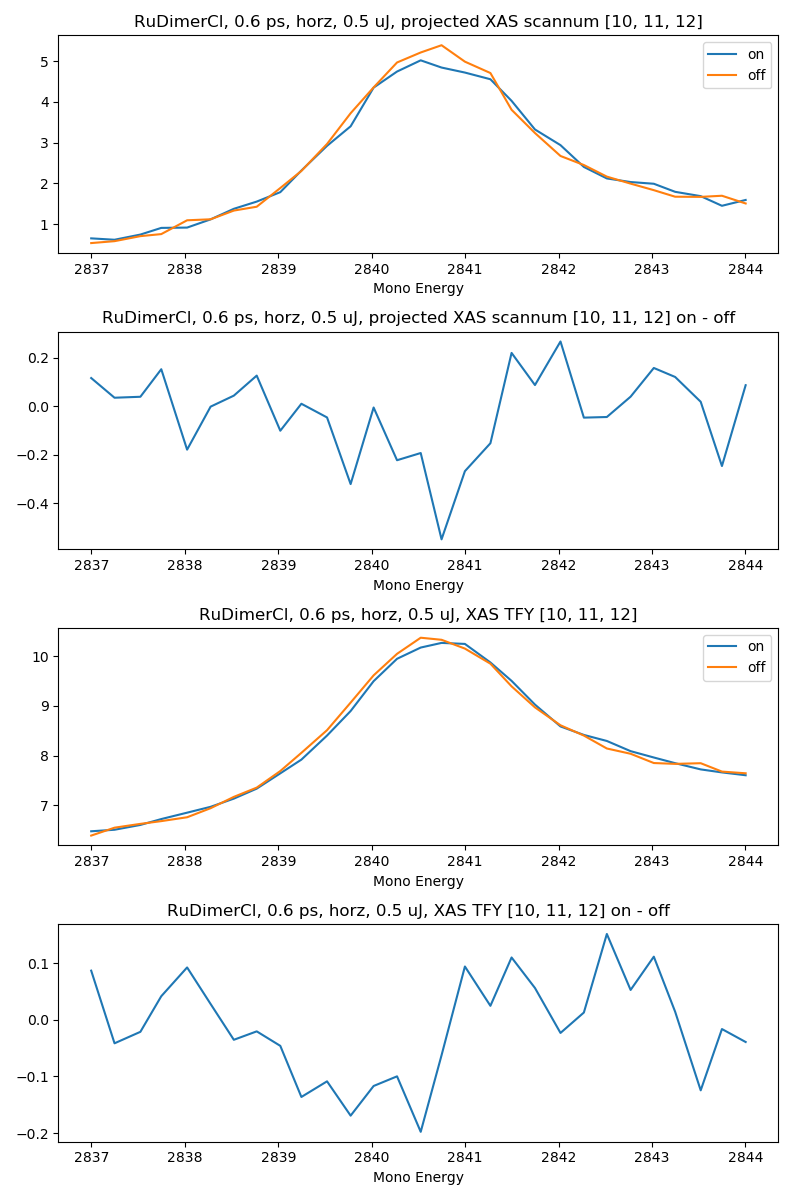

In [14]:
plot_projected_XAS(\
       label_01, scannum_01, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01, Fluo_pump_01, Fluo_unpump_01)
# plot_projected_XAS(\
#        label_02, scannum_02, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02, Fluo_pump_02, Fluo_unpump_02)
# plot_projected_XAS(\
#        label_03, scannum_03, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03, Fluo_pump_03, Fluo_unpump_03)

In [15]:
# plot_projected_XES(\
#        label_03, scannum_03, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03, Fluo_pump_03, Fluo_unpump_03)


<IPython.core.display.Javascript object>


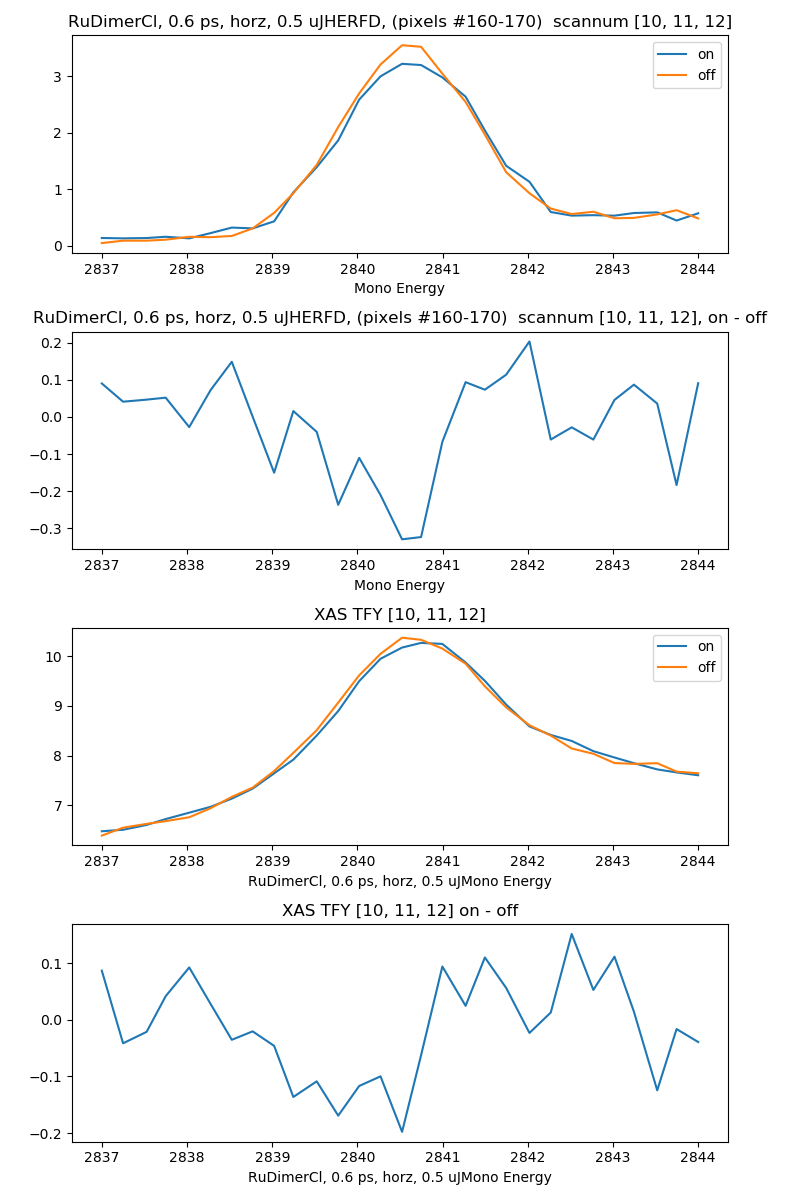

In [16]:
pixel_range_max = 170
pixel_range_min = 160

diff_01, diff_fluo_01 = plot_herfd(label_01, scannum_01, pixel_range_min, pixel_range_max,\
           eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01, Fluo_pump_01, Fluo_unpump_01)

# diff_03, diff_fluo_03 = plot_herfd(label_03, scannum_03, pixel_range_min, pixel_range_max,\
#            eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03, Fluo_pump_03, Fluo_unpump_03)

# diff_04, diff_fluo_04 = plot_herfd(label_04, scannum_04, pixel_range_min, pixel_range_max,\
#            eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04, Fluo_pump_04, Fluo_unpump_04)

# plt.figure()
# plt.plot(eV_off_03, diff_03)
# plt.plot(eV_off_04, diff_04)

# plt.figure()
# plt.plot(eV_off_03, diff_fluo_03/Fluo_pump_03)
# plt.plot(eV_off_04, diff_fluo_04/Fluo_pump_04)

In [17]:
# diff_02, diff_fluo_02 = plot_herfd(label_02, scannum_02, pixel_range_min, pixel_range_max,\
#            eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02, Fluo_pump_02, Fluo_unpump_02)

<IPython.core.display.Javascript object>


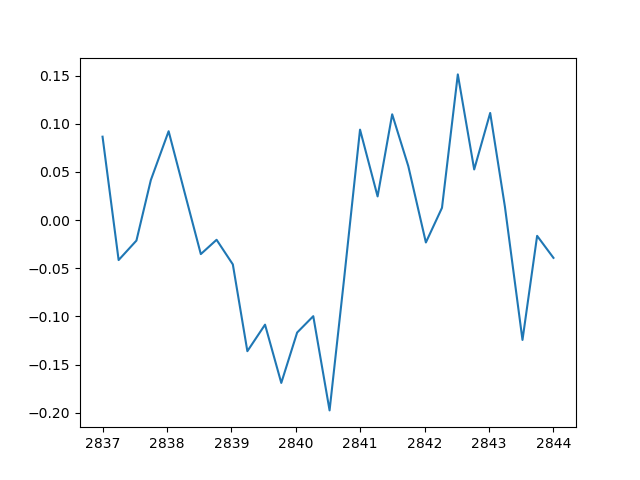

In [18]:
plt.figure()
plt.plot(eV_off_01, diff_fluo_01)
# plt.plot(eV_off_02, diff_fluo_02)


mono_max
2837.246809428397
mono_min
2836.9970151018456


<IPython.core.display.Javascript object>


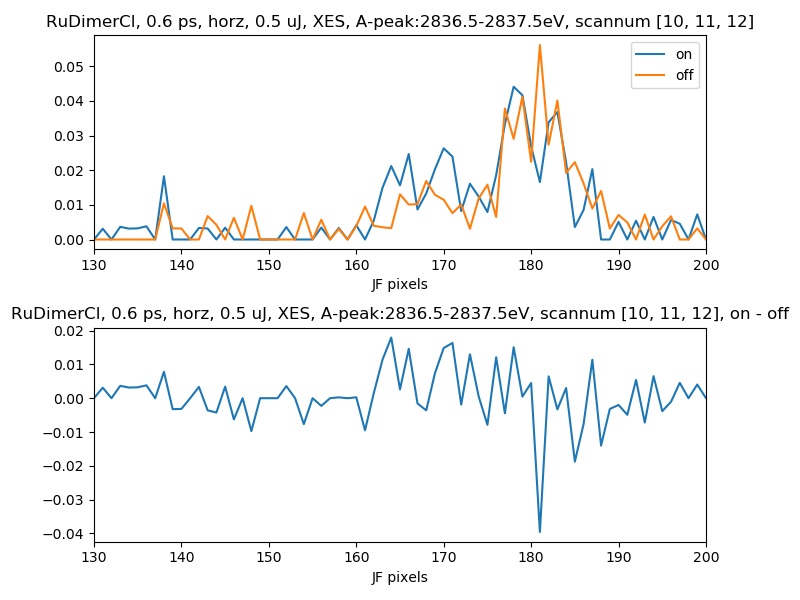

In [19]:
mono_range_min = 2836.5
mono_range_max = 2837.5
peak_label = 'A-peak'

cie_diff_01 = plot_cie(peak_label, label_01, scannum_01, \
                       mono_range_min, mono_range_max, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01)
# plot_cie(peak_label, label_03, scannum_03, mono_range_min, mono_range_max, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)
# plot_cie(peak_label, label_04, scannum_04, mono_range_min, mono_range_max, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

In [20]:
# diff_cie_02 = plot_cie(peak_label, label_02, scannum_02, \
#                        mono_range_min, mono_range_max, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02)

In [21]:
mono_range_min = 2840
mono_range_max = 2841
peak_label = 'B-peak'

mono_max
2840.997375530869
mono_min
2840.020107007201


<IPython.core.display.Javascript object>


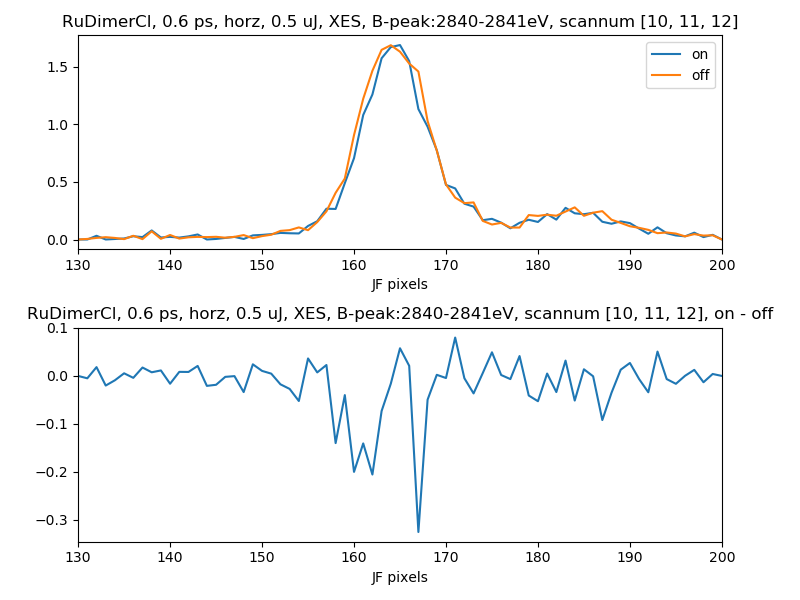

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [22]:
plot_cie(peak_label, label_01, scannum_01, mono_range_min, mono_range_max, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01)

In [23]:
# plot_cie(peak_label, label_02, scannum_02, mono_range_min, mono_range_max, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02)

In [24]:
# plot_cie(peak_label, label_03, scannum_03, mono_range_min, mono_range_max, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)

In [25]:
# plot_cie(peak_label, label_04, scannum_04, mono_range_min, mono_range_max, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

mono_max
2842.270830581332
mono_min
2841.74721651344


<IPython.core.display.Javascript object>


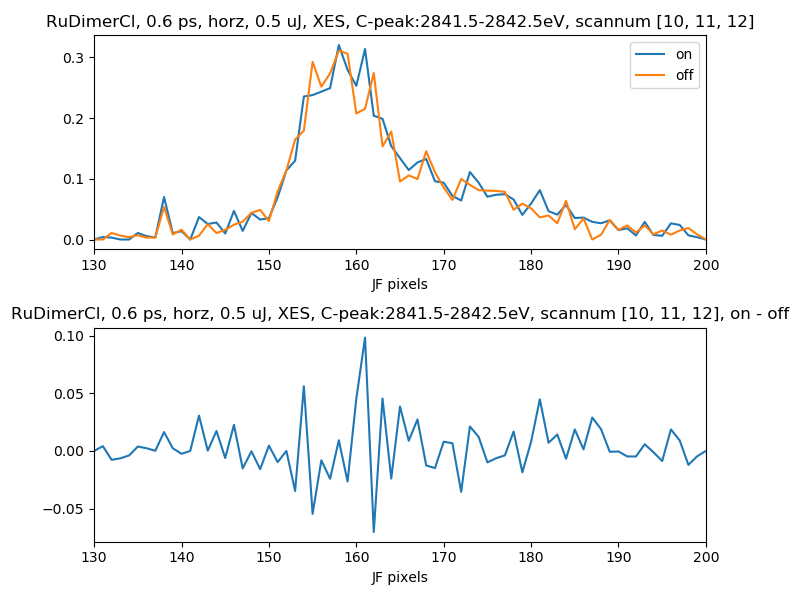

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [26]:
mono_range_min = 2841.5
mono_range_max = 2842.5
peak_label = 'C-peak'

plot_cie(peak_label, label_01, scannum_01, mono_range_min, mono_range_max, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01)

In [27]:
# plot_cie(peak_label, label_02, scannum_02, mono_range_min, mono_range_max, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02)

In [28]:
# plot_cie(peak_label, label_03, scannum_03, mono_range_min, mono_range_max, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)

In [29]:
# plot_cie(peak_label, label_04, scannum_04, mono_range_min, mono_range_max, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

In [30]:
mono_range_min = 2843
mono_range_max = 2844
peak_label = 'C-peak'

# plot_cie(peak_label, label_03, scannum_03, mono_range_min, mono_range_max, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)
# plot_cie(peak_label, label_04, scannum_04, mono_range_min, mono_range_max, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

In [31]:
# mono_range_min = 2845
# mono_range_max = 2846
# peak_label = 'C-peak'

# plot_cie(peak_label, label_01, scannum_01, mono_range_min, mono_range_max, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01)

In [32]:
# plot_cie(peak_label, label_02, scannum_02, mono_range_min, mono_range_max, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02)

In [33]:
# plot_cie(peak_label, label_03, scannum_03, mono_range_min, mono_range_max, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)

In [34]:
# plot_cie(peak_label, label_04, scannum_04, mono_range_min, mono_range_max, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

In [35]:



# plt.figure(figsize=(8,3))
# plt.plot((RIXS_on_01[index_min:index_max].sum(axis=0))/3, label = str(scannum_01) + "on")
# plt.plot((RIXS_on_02[index_min:index_max].sum(axis=0))/2, label = str(scannum_02) + "on")
# plt.xlabel('JF pixels')
# plt.title('mono XES scannum')
# plt.xlim([130,200])
# plt.legend()
# plt.tight_layout()

# plt.figure(figsize=(8,3))
# plt.plot((RIXS_off_01[index_min:index_max].sum(axis=0))/3, label = str(scannum_01) + "off")
# plt.plot((RIXS_off_02[index_min:index_max].sum(axis=0))/2, label = str(scannum_02) + "off")
# plt.xlabel('JF pixels')
# plt.title('mono XES scannum')
# plt.xlim([130,200])
# plt.legend()
# plt.tight_layout()




In [36]:
eV_on_01<2842

array([False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])